# Задание №2: Фрактальное сжатие


## Код программы

In [7]:
# Standard Python Library

import os
import itertools

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

import tests

Первым делом нужно загрузить картинку

In [8]:
lenna_rgb_512x512 = io.imread('test_files/lenna.bmp')
lenna_rgb_256x256 = np.rint(resize(lenna_rgb_512x512, (256, 256)) * 255).astype('uint8')
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')
lenna_gray_128x128 = np.rint(resize(lenna_gray_256x256, (128,128)) * 255).astype('uint8')
lenna_gray_32x32 = np.rint(resize(lenna_gray_256x256, (32,32)) * 255).astype('uint8')
lenna_gray_16x16 = np.rint(resize(lenna_gray_256x256, (16,16)) * 255).astype('uint8')
lenna_gray_512x512 = np.rint(rgb2gray(lenna_rgb_512x512) * 255).astype('uint8')
baboon = io.imread('test_files/baboon.bmp')
lenna_gray_64x64 = np.rint(resize(lenna_gray_256x256, (64, 64)) * 255).astype(np.uint8)
baboon = np.rint(resize(baboon, (256, 256)) * 255).astype(np.uint8)

`plt` — модуль для рисования графиков и всего остального

Очень удобная штука, будем пользоваться ей довольно часто

In [9]:
# GRADED CELL: BlockTransform

BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'tr'])

In [10]:
# GRADED CELL: FractalCompressionParams

FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
        'spatial_scale',
        'intensity_scale',
        'stride'
    ]
)

domain_block = namedtuple(  # Структура, описывающая доменный блок. 
    'domain_block', [
        'x',  # положение по оси х
        'y',  # положение по оси у
        'r',  # поворот - число от 0 до 3. отражениие блока не производится, потому что программа работает долго. upd. решил совсем убрать
        'sum_d',  # сумма яркости в блоке
        'sum_sqr_d',  # сумма квадратов яркостей в блоке
    ]
)
rank_block = namedtuple( # Структура, описывающая ранговый блок, нужна для поддержки квадродерева
    'rank_block', [
        'x', # положение по оси х
        'y', # положение по оси у
        'size' # Размер - число от 2 до 16 (4 до 32 в случае UV компонент)
    ]
)

In [11]:
def is_colored(image):
    '''
    Определяет размерность матрицы т.е. цвет изображения
    '''
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))

In [40]:
# GRADED CELL: find_block_transform

def find_block_transform(image, resized_image, x, y, block_size,
                         domains, eyes, error):
    """
    Функция, находящая наиболее удачную трансформацию.
    Все вычисления производятся в float для сохранения точности
    """
    def _calculate_quadrants(rank):
        '''
        Функция, вычисляющая значения квадрантов блока
        и возвращающая порядок блоков по порядку
        Пример: пусть есть ранговый блок Ri, разбитый на 4 квадранта
        r1|r2
        ----- функция считает сумму яркостей в квадрантах и упорядочивает их
        r3|r4 всего вариантов упорядочить 4 квадранта: 4*3*2*1 = 4! = 24
        '''
        quadrants = {}
        for i in range(4):
            quadrants[str(i + 1)] = np.sum(eyes[i] * rank)  # сумма блока с маской
        lol = sorted(quadrants, key=quadrants.get, reverse=True)  # возвращаемое значение - строка
        return ''.join(lol)
    def myinterp(val, src, dst):
        """
        Функция, отображающая отрезок src->dst
        Пришла на замену np.interp и заметно (почти в 2 раза) ускорила работу программы
        """
        if (src[1] - src[0]) != 0:
            value = ((val - src[0]) / (src[1] - src[0])) * (dst[1] - dst[0]) + dst[0]
            # к моему удивлению, np.clip тоже работает долго
            return np.max([np.min([value, dst[1]]), dst[0]])
        else:
            return 0.0
    def myinterp2(val, src, dst):
        """
        Функция, отображающая отрезок src->dst
        Пришла на замену np.interp и заметно (почти в 2 раза) ускорила работу программы
        """
        if (src[1] - src[0]) != 0:
            value = ((val - src[0]) / (src[1] - src[0])) * (dst[1] - dst[0]) + dst[0]
            # к моему удивлению, np.clip тоже работает долго
            return value
        else:
            return 0.0
    def shift_string(pos1, pos2, string):
        cpy = list(string).copy()
        tmp = cpy[pos1]
        cpy[pos1] = cpy[pos2]
        cpy[pos2] = tmp
        return ''.join(cpy)
    
    x_tmp = 0  # костыль
    y_tmp = 0  #
    p_tmp = 0  #
    q_tmp = 0  #
    Ri = image[y:y + block_size, x:x + block_size]  # вырезаем из матрицы ранговый блок
    sumr = np.sum(Ri)  # сумма яркостей в блоке
    sumsqr = np.sum(
        Ri * Ri)  # сумма квадратов яркостей. Так как сравнение с ранговым блоком проходит 1 раз, нет необходимости
    # предварительно считать эти значения
    L2_min = 1000000000  # большое число, здесь будет храниться лучшее значение
    rtype = _calculate_quadrants(Ri)  # получаем значение рангового блока
    lendom  = len(domains[block_size][rtype])
    rtype3 = rtype[::-1]
    search_pool = domains[block_size][rtype] + domains[block_size][rtype3][:lendom//5]
    for dom in search_pool:  
        # ищем по всем заранее посчитанным доменным блокам такого же типа (одного из 24)
        # + 1/5 блоков противоположного типа
        i = dom.y
        j = dom.x
        n_of_pixels = block_size ** 2
        Di = resized_image[i:i + block_size, j:j + block_size]  # вырезаем из уменьшенного изображения доменный блок
        sumrd = np.sum(Ri * Di)
        sumd = dom.sum_d
        sumsqd = dom.sum_sqr_d

        div = n_of_pixels * sumsqd - sumd * sumd  # в этой части функции мы подбираем самые оптимальные значения яркости и смещения
        if div != 0:  # продифференцировав по p и q и приравняв производные к нулю, находим лучшие
            p = (n_of_pixels * sumrd - sumr * sumd) / div  # значения и считаем ошибку, возведя в квадрат и раскрыв скобки
        else:
            p = 0
        pscale = np.floor(myinterp(p, (-1.0, 1.0), (0, 31))).astype(int)  # квантуем значения для сохранения в массив
        pscaler = myinterp2(pscale, (0, 31),
                            (-1.0, 1.0))  # значение яркости находится от -1 до 1 для "гибкости" подбора похожих блоков
        q = (sumr - pscaler * sumd) / n_of_pixels
        qscale = np.floor(myinterp(q, (-1.0 * pscaler, 1.0), (0, 127))).astype(int)  # квантуем значения для сохранения в массив
        qscaler = myinterp2(qscale, (0, 127), (-1.0 * pscaler, 1.0))
        L2 = (pscaler * (pscaler * sumsqd - 2 * sumrd + 2 * qscaler * sumd) + qscaler * (
                n_of_pixels * qscaler - 2 * sumr) + sumsqr) / n_of_pixels  # не берем квадратный корень
        if L2 < L2_min:
            L2_min = L2
            x_tmp = j
            y_tmp = i
            p_tmp = pscale
            q_tmp = qscale

    best_transform = BlockTransform(x_tmp, y_tmp, p_tmp, q_tmp)
    return best_transform, L2_min  # возвращаем лучшее преобразование и ошибку

In [41]:
# GRADED CELL: perform_transform

def perform_transform(image, resized_image, transforms, rank_blocks):
    def myinterp(val, src, dst):
        if (src[1] - src[0]) != 0:
            value = ((val - src[0]) / (src[1] - src[0])) * (dst[1] - dst[0]) + dst[0]
            return value
        else:
            return 0.0
    transformed_image = np.zeros((image.shape[1], image.shape[0]))
    for tmp, rank in zip(transforms, rank_blocks):  # в цикле по всем ранговым блокам
        i = rank.y                                  # последовательно применяем преобразования
        j = rank.x
        block_size = rank.size
        pscaler = myinterp(tmp.di, (0, 31), (-1.0, 1.0))
        qscaler = myinterp(tmp.tr, (0, 127), (-1.0 * pscaler, 1.0))
        transformed_image[i:i + block_size, j:j + block_size] = np.clip(resized_image[tmp.y:tmp.y + block_size,
                                                                                 tmp.x:tmp.x + block_size] * pscaler + qscaler,
                                                                        0, 1)
    return transformed_image

In [42]:
# GRADED CELL: BitBuffer

class BitBuffer:
    '''
    Класс ввода вывода
    '''
    def __init__(self, buffer=None):
        self.buffer = bytearray()
        self.output_mask = 0x80
        self.input_mask = 0x80
        self.bits_to_output = 0
        self.bits_to_input = 0

    def to_bytearray(self):
        self.buffer.append(self.bits_to_output)
        self.output_mask = 0x80
        self.bits_to_output = 0
        return self.buffer

    def flush(self):
        if self.output_mask != 0x80:
            self.buffer.append(self.bits_to_output)
            self.output_mask = 0x80
            self.bits_to_output = 0

    def input_bit(self):
        current_bit = 0
        if self.input_mask == 0x80:
            self.bits_to_input = self.buffer.pop(0)
        current_bit = self.input_mask & self.bits_to_input
        self.input_mask >>= 1
        if self.input_mask == 0:
            self.input_mask = 0x80
        return current_bit != 0

    def output_bit(self, bit):
        if bit:
            self.bits_to_output |= self.output_mask
        self.output_mask >>= 1
        if self.output_mask == 0:
            self.to_bytearray()

    def push(self, x, n_bits):
        mask = 1 << (n_bits - 1)
        while mask != 0:
            if mask & x:
                self.bits_to_output |= self.output_mask
            self.output_mask >>= 1
            if self.output_mask == 0:
                self.to_bytearray()
            mask >>= 1

    def pop(self, n_bits):
        mask = 1 << (n_bits - 1)
        x = 0
        while mask != 0:
            if self.input_mask == 0x80:
                self.bits_to_input = self.buffer.pop(0)
            if self.bits_to_input & self.input_mask:
                x |= mask
            mask >>= 1
            self.input_mask >>= 1
            if self.input_mask == 0:
                self.input_mask = 0x80
        return x

In [43]:
# GRADED CELL: FractalCompressor

class FractalCompressor:
    '''
    Основной класс
    '''

    def __init__(self):
        self._num_bits_ver = 7  # число бит, необходимое для кодирования положения по х в изображении 128 * 128
        self._num_bits_hor = 7  # число бит, необходимое для кодирования положения по у в изображении 128 * 128
        self._num_bits_pix = 5  # число бит под яркость
        self._num_bits_tfm = 7  # число бит под смещение
        self.max_block_size = 16  # максимальный размер рангового блока (32 для UV)
        self.min_block_size = 2  # минимальный (4 для UV)
        self.max_error = 0.04  # пороговое значение ошибки

    def _makeeyes(self, block_size):
        '''
        Функция, создающая маски определенного размера
        вида E|O  O|E
             ---  --- ...
             O|O  O|O
        '''
        tmp = (block_size // 2, block_size // 2)
        eye1 = np.block([
            [np.ones(tmp), np.zeros(tmp)],
            [np.zeros(tmp), np.zeros(tmp)]
        ]).astype(np.uint8)
        eye2 = np.block([
            [np.zeros(tmp), np.ones(tmp)],
            [np.zeros(tmp), np.zeros(tmp)]
        ]).astype(np.uint8)
        eye3 = np.transpose(eye2).astype(np.uint8)
        eye4 = np.block([
            [np.zeros(tmp), np.zeros(tmp)],
            [np.zeros(tmp), np.ones(tmp)]
        ]).astype(np.uint8)
        return [eye1, eye2, eye3, eye4]

    def _add_header(self, buffer, params):
        """
        Кодируем заголовок в файл

        """
        buffer.push(params[0], self._num_bits_hor + 2)
        buffer.push(params[1], self._num_bits_ver + 2)
        buffer.push(params[2], 1)
        buffer.push(params[3], 8)

    def _read_header(self, buffer):
        """
        Достаем заголовок из файла
        """
        params = FractalCompressionParams(buffer.pop(self._num_bits_hor + 2), buffer.pop(self._num_bits_ver + 2),
                                          buffer.pop(1), buffer.pop(8), 0, 0, 0)
        return params

    def _add_to_buffer(self, buffer, transform):
        """
        Кодируем преобразование
        """
        buffer.push(transform.x, self._num_bits_hor)
        buffer.push(transform.y, self._num_bits_ver)
        buffer.push(transform.di, self._num_bits_pix)
        buffer.push(transform.tr, self._num_bits_tfm)

    def _read_transform(self, buffer):
        '''
        Читаем преобразование
        '''
        transform = BlockTransform(buffer.pop(self._num_bits_hor), buffer.pop(self._num_bits_ver),
                                   buffer.pop(self._num_bits_pix), buffer.pop(self._num_bits_tfm),)
        return transform

    def _calculate_quadrants(self, domain, eyes):
        """
        См функцию find_block_transform
        """
        quadrants = {}
        for i in range(4):
            quadrants[str(i + 1)] = np.sum(eyes[i] * domain)
        lol = sorted(quadrants, key=quadrants.get, reverse=True)
        return ''.join(lol)

    def _create_domains(self, image, block_size, stride, eyes):
        """
        функция, создающая словарь 24 типов доменных блоков одного размера
        в дальнейшем по этим блокам будет проходить сравнение рангового блока
        """
        x = list(map("".join, itertools.permutations('1234')))
        dct = {}
        for i in x:
            dct[i] = []
        for y in range(0, image.shape[0] - block_size, stride):
            for x in range(0, image.shape[1] - block_size, stride):
                sum_d = np.sum(image[y:y + block_size, x:x + block_size])
                sum_sqr_d = np.sum(image[y:y + block_size, x:x + block_size] *
                                   image[y:y + block_size, x:x + block_size])
                tmp = image[y:y + block_size, x:x + block_size]
                dct[self._calculate_quadrants(tmp, eyes)].append(domain_block(x, y, 0, sum_d, sum_sqr_d))
        return dct

    def compress(self, image, clr=0, uv=1):
        '''
        Процедура сжатия одной матрицы
        '''
        buffer = BitBuffer()
        eye = {16 * uv: self._makeeyes(16 * uv), 8 * uv: self._makeeyes(8 * uv), 4 * uv: self._makeeyes(4 * uv),
               2 * uv: self._makeeyes(2 * uv)}
        resized_image = resize(image / 255, (image.shape[0] // 2, image.shape[1] // 2)).astype(np.float64)
        # для U и V необходимо уменьшить размер блоков
        self.max_block_size *= uv
        self.min_block_size *= uv
        '''
        создаем словарь для блоков всех размеров
        Чем больше блоков - тем больше сравнений с ранговым блоком и тем
        выше шанс найти лучший. Помимо этого, если мы для блока большого размера
        находим подходящий блок, мы не спускаемся вниз по квадродереву - то есть
        уменьшаем размер массива bytearray. Проблема в том, что большой перебор
        увеличивает время работы программы
        '''
        domains = {16 * uv: self._create_domains(resized_image, block_size=16 * uv, stride=1 * uv, eyes=eye[16 * uv]),
                   8 * uv: self._create_domains(resized_image, block_size=8 * uv, stride=1 * uv, eyes=eye[8 * uv]),
                   4 * uv: self._create_domains(resized_image, block_size=4 * uv, stride=1 * uv, eyes=eye[4 * uv]),
                   2 * uv: self._create_domains(resized_image, block_size=2 * uv, stride=1 * uv, eyes=eye[2 * uv])}
        image = image.astype(np.float64) / 255
        params = FractalCompressionParams(image.shape[0], image.shape[1], clr, 0, 0, 0, 0)
        self._add_header(buffer, params)
        # основная процедура
        self._quadtree(0, 0, image.shape[0], image, resized_image, domains, buffer, eye)

        self.max_block_size /= uv  # костыль n2
        self.min_block_size /= uv
        buffer.flush()
        return buffer.buffer

    def _quadtree(self, x, y, block_size, image, resized_image, domains, buffer, eye):
        '''
        Квадродерево
        '''
        if block_size > self.max_block_size:  # если блок ещё слишком большой, идем вниз
            buffer.output_bit(0)  # нолик для декодера
            params = [block_size // 2, image, resized_image, domains, buffer, eye]
            self._quadtree(x, y, *params)
            self._quadtree(x, y + block_size // 2, *params)
            self._quadtree(x + block_size // 2, y, *params)
            self._quadtree(x + block_size // 2, y + block_size // 2, *params)
        else:
            transform, error = find_block_transform(image, resized_image, x, y, block_size, domains, eye[block_size], self.max_error)
            if error * block_size * block_size > self.max_error and block_size > self.min_block_size:
                buffer.output_bit(0)  # если ошибка все ещё слшиком большая, делим блок
                params = [image, resized_image, domains, buffer, eye]
                self._quadtree(x, y, block_size // 2, *params)
                self._quadtree(x, y + block_size // 2, block_size // 2, *params)
                self._quadtree(x + block_size // 2, y, block_size // 2, *params)
                self._quadtree(x + block_size // 2, y + block_size // 2, block_size // 2, *params)
            else:
                if block_size != self.min_block_size:  # сохраняем подходящее преобразование, кладем единичку в файл
                    buffer.output_bit(1)  # если мы на самом нижнем уровне, декодер знает, что дальше следует
                self._add_to_buffer(buffer, transform)

    def _dquadtree(self, x, y, block_size, buffer, transforms, rank_blocks):
        '''
        Аналогичное квадродерево для декордера
        '''
        if block_size == self.min_block_size or buffer.input_bit():
            rank_blocks.append(rank_block(x, y, block_size))
            transforms.append(self._read_transform(buffer))
        else:
            params = [block_size // 2, buffer, transforms, rank_blocks]
            self._dquadtree(x, y, *params)
            self._dquadtree(x, y + block_size // 2, *params)
            self._dquadtree(x + block_size // 2, y, *params)
            self._dquadtree(x + block_size // 2, y + block_size // 2, *params)

    def compress2(self, image, quality=0):
        '''
        Ручка качества) Числа подобраны так, чтобы график был красивый
        '''
        quality_to_error = {0: 10, 20: 0.8 * 0.8, 40: 0.65 * 0.65, 60: 0.4 * 0.4,
                            80: 0.3 * 0.3, 100: 0.2 * 0.2}
        self.max_error = quality_to_error[quality]
        if is_colored(image):  # если картинка цветная, кодируем по отдельности каждую матрицу, затем склеиваем
            tmp = rgb2yuv(image)  # переводим в YUV, потому что кодирование в RGB - путь лемминга
            a = tmp[:, :, 0] * 255
            b = (tmp[:, :, 1] + 0.5) * 255  # избавляемся от отрицательных значений
            c = (tmp[:, :, 2] + 0.5) * 255
            cmp = self.compress(a, clr=1) + self.compress(b, uv=2) + self.compress(c, uv=2)
        else:
            cmp = self.compress(image)
        return cmp

    def _unpack(self, params, num_iters, buffer):
        '''
        Раскодируем и преобразовываем матрицу
        '''
        tmp = np.zeros((params.height, params.width), dtype=np.float64)
        tmp_r = resize(tmp, (tmp.shape[0] // 2, tmp.shape[1] // 2)).astype(np.float64)
        transforms = []
        rank_blocks = []
        self._dquadtree(0, 0, params.width, buffer, transforms, rank_blocks)
        for i in range(num_iters):
            tmp = perform_transform(tmp, tmp_r, transforms, rank_blocks)
            tmp_r = resize(tmp, (tmp.shape[0] // 2, tmp.shape[1] // 2)).astype(np.float64)
        buffer.input_mask = 0x80  # костыль n1
        buffer.bits_to_input = 0
        return tmp

    def decompress(self, byte_array, num_iters=16):
        buffer = BitBuffer()
        buffer.buffer = byte_array.copy()
        params = self._read_header(buffer)
        if params.is_colored:
            y = self._unpack(params, num_iters, buffer)
            self.min_block_size *= 2
            self.max_block_size *= 2
            up = self._read_header(buffer)
            u = self._unpack(up, num_iters, buffer) - 0.5
            vp = self._read_header(buffer)
            v = self._unpack(vp, num_iters, buffer) - 0.5
            x = np.dstack([y, u, v])
            res = np.clip(yuv2rgb(x), 0, 1)
            self.min_block_size /= 2  # костыль 2
            self.max_block_size /= 2
        else:
            res = self._unpack(params, num_iters, buffer)
        return np.rint(res * 255).astype(np.uint8)

## Пробуем применить FractalCompressor

In [44]:
comp = FractalCompressor()

In [52]:
%%time
x = comp.compress2(lenna_rgb_256x256, 100) # максимальное качество

CPU times: user 2min 13s, sys: 585 ms, total: 2min 14s
Wall time: 2min 13s


Размер сжатого изображения в байтах == длина полученного массива `bytearray`

In [50]:
len(x)

1322

In [51]:
%%time
img = comp.decompress(x)
weighted_psnr(lenna_rgb_256x256, img)

CPU times: user 280 ms, sys: 310 ms, total: 590 ms
Wall time: 198 ms


27.284846506611398

### Эволюция изображения при декомпрессии
Выглlenna_rgb_256x256личение фотографии в CSI: Место прреступления

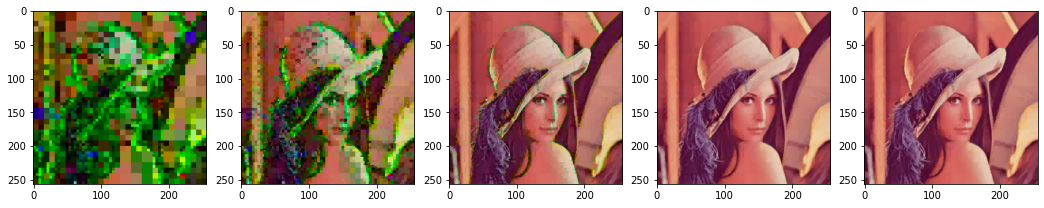

In [15]:
n_iters = [1, 2, 4, 8, 16]

imgs = [comp.decompress(x, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

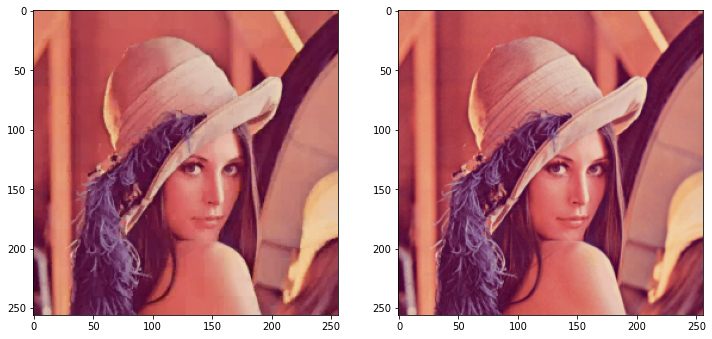

In [248]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(lenna_rgb_256x256, cmap='gray') # а ведь похожа!

## Эксперименты

In [35]:
def weighted_psnr(ref, img):
    assert ref.shape == img.shape, "Shape mismatch"
    if is_colored(img):
        ref_yuv = rgb2yuv(ref)
        img_yuv = rgb2yuv(img)
        
        return (4 * psnr(ref_yuv[..., 0], img_yuv[..., 0]) +
                    psnr(ref_yuv[..., 1], img_yuv[..., 1]) +
                    psnr(ref_yuv[..., 2], img_yuv[..., 2])
               ) / 6
    else:
        return psnr(ref, img)

In [94]:
from timeit import Timer

In [102]:
quality = [0, 20, 40, 60, 80, 100, 120]

def test_image(img):
    compressed_images = [comp.compress2(img, quality=q) for q in quality]
    decompressed_images = [comp.decompress(compressed) for compressed in compressed_images]
    compression_rates = np.array([len(compressed) for compressed in compressed_images])
    psnrs = [weighted_psnr(img, decompressed) for decompressed in decompressed_images]
    return compression_rates, psnrs

На этом моменте я поменял тестовую выборку, вместо baboon.bmp я взял peppers.bmp, потому что бабуин вычисляется очень долго

In [103]:
def test_and_plot_collection(collection):
    _, ax = plt.subplots(figsize=(8, 6))

    for image in collection:
        compression_rates, psnrs = test_image(image)
        ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')

    ax.set_xlabel('Compression Rate', fontsize=16)
    ax.set_ylabel('PSNR, dB', fontsize=16)

    plt.show()

4min 57s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


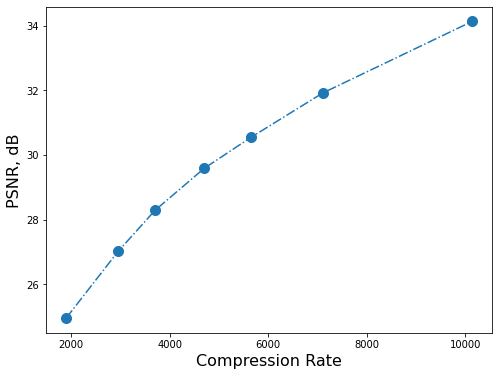

CPU times: user 4min 57s, sys: 11 s, total: 5min 8s
Wall time: 4min 57s


In [100]:
%%time
test_and_plot_collection([lenna_gray_256x256]) # график для черно-белой Лены

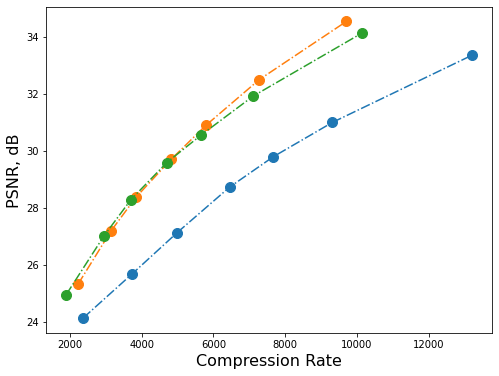

CPU times: user 18min 41s, sys: 35.2 s, total: 19min 16s
Wall time: 18min 47s


In [104]:
%%time
collection = []
for image_name in os.listdir('images'):
    image = resize(io.imread(os.path.join('images', image_name)), (256, 256))
    if is_colored(image):
        image = np.rint(rgb2gray(image) * 255).astype('uint8')
    collection.append(image)
test_and_plot_collection(collection)

### Теперь изменим параметры компрессора. Для каждого размера доменного блока поставим шаг 4 пикселя.
(Код измененного компрессора в скрытой ячейке)

In [123]:
comp1 = FractalCompressor1()

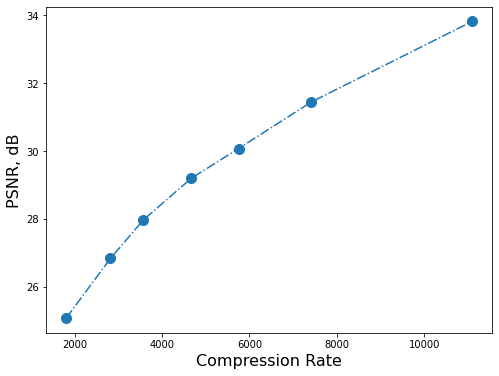

CPU times: user 1min 42s, sys: 9.97 s, total: 1min 52s
Wall time: 1min 40s


In [118]:
%%time
test_and_plot_collection([lenna_gray_256x256]) # график для черно-белой Лены

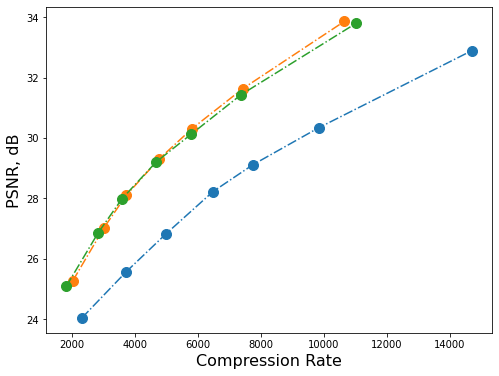

CPU times: user 6min 1s, sys: 33.9 s, total: 6min 35s
Wall time: 5min 58s


In [119]:
%%time
test_and_plot_collection(collection)

Мы получили весьма интересные результаты.

Во-первых, качество ухудшилось не сильно - 0.5-1 децибел при каждом значении качества

Во-вторых, увеличился размер файла для каждого значения качества, это происходит, потому что из-за недостатка
доменных блоков нам приходистся спускаться все ниже и ниже, что увеличивает размер файла.

В-третьих, алгоритм стал заметно быстрее, общее время работы составило порядка 6 минут вместо 18 в изначальной конфигурации.

### Теперь для каждого блока определим шаг, равный двум пикселям

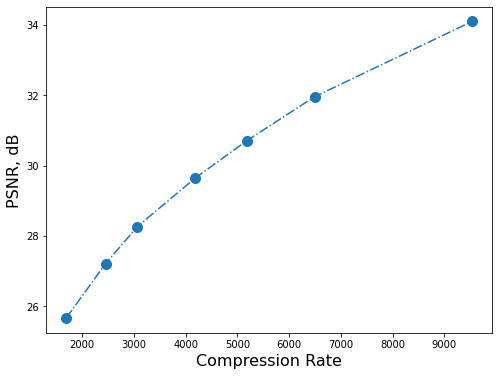

CPU times: user 5min 20s, sys: 9.45 s, total: 5min 30s
Wall time: 5min 20s


In [124]:
%%time
test_and_plot_collection([lenna_gray_256x256])

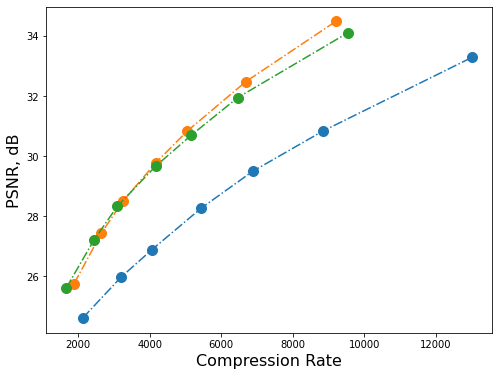

CPU times: user 19min 7s, sys: 31.3 s, total: 19min 39s
Wall time: 19min 10s


In [125]:
%%time
test_and_plot_collection(collection)

Итак, качество не изменилось по сравнению с изначальной конфигурацией, а размер файла уменьшился благодаря
нахождению блоков на начальных этапах. Время также не сильно изменилось.
Кажется, стоит выбрать эту стратегию как основную.

## Почти итоги

Тут должно были быть результаты дальнейшних экспериментов, но ~~я хочу спать.~~ у меня не хватило времени это оформить, так что напишу текстом.

Во-первых, я предпринял попытки по ускорению алгоритма. Первая идея - выходить из цикла в функции find_block_transform при нахождении блока, который дает ошибку меньше наперед заданной. При такой стратегии скорость увеличивалась, размер не менялся а качество падало, так что я от этого отказался.

Во-вторых, я заметил, что если не поворачивать блоки, а перебирать с меньшим шагом, то качество падает не сильно, а на кодировании поворота можно неплохо сэкономить - по 2 бита на каждую трансформацию. Наверное, это связано с тем, что картинки "неповоротливые" и достаточно параллельного переноса

В-третьих, я заметил, что функция np.interp работает очень долго, из-за чего у меня падал последний тест из-за TL, исправил это, написав myinterp

## Отчет

В заключение мне хотелось бы описать все принципиальные особенности моего алгоритма, а также рассказать,
как неописанные ранее эксперименты влияли на результат
### Особенности:

Простое квадродерево, делящееся при большой ошибке, ошибка умножается на размер блока.

Все вычисления производятся в типе float для сохранения точности.

Использование отрицательного контраста.

Разбиение доменных блоков на 24 типа по яркости квадрантов.

### Что ухудшало результат:
Контраст по модулю больше 1.

Разбиение доменных блоков по их особенностям (фичам).

Сохранение блоков 2х2 напрямую.

Повороты блоков(внезапно).

Что ещё плохо:
качество моего кода

скорость работы

смешные баги, возникшие при написании кода:https://drive.google.com/drive/folders/1BJj8uBeJ02cUxo0EuqTPhlmQp_l1R0KS?usp=sharing